# The dataset: `bigquery-public-data.usa_names.usa_1910_current`

This dataset contains historical records of baby names registered in the United States from the year 1910 onwards. It is publicly hosted on Google BigQuery as part of Google's public datasets.

## Source

The data originates from the U.S. Social Security Administration (SSA) and includes aggregated birth name information by year, gender, and state.

## Columns Description

| Column   | Type    | Description |
|----------|---------|-------------|
| `name`   | STRING  | The first name of the baby. |
| `gender` | STRING  | The gender associated with the name: either `"M"` (Male) or `"F"` (Female). |
| `state`  | STRING  | The U.S. state abbreviation (e.g., "CA", "NY"). In some entries this field may be null. |
| `year`   | INTEGER | The year in which the name was registered. |
| `number` | INTEGER | The number of babies given this name in that year and state. |

## Target / Label Column

There is no explicit label column in this dataset, as it is not originally designed for supervised machine learning tasks. However, depending on the goal of the analysis, one can define a target. For example:
- In a **gender prediction task**, the column `gender` can serve as the label.
- For **popularity prediction**, the column `number` or its change over time could be used as a target variable.

## Use Cases

This dataset is suitable for a variety of data science and analytics tasks, including:
- Trend analysis of baby name popularity over time.
- Gender distribution of names.
- Identification of unisex (gender-neutral) names.
- Forecasting future popularity of specific names.
- Sociocultural studies (e.g., names influenced by events, celebrities, or politics).

## Dataset Characteristics

- Total rows: ~1.8 million (depending on filters).
- Time range: 1910 to present.
- Granularity: Yearly.
- Aggregated: Not individual-level data, but grouped by name/year/state/gender.

## Example Query (SQL)

```sql
SELECT name, SUM(number) AS total
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE gender = 'F'
GROUP BY name
ORDER BY total DESC
LIMIT 10;


In [1]:
!pip install -q google-cloud-bigquery

In [3]:
# from google.colab import auth  # disabled for Git compatibility
# auth.authenticate_user()  # disabled for Git compatibility

In [6]:
from google.cloud import bigquery

project_id = "custom-helix-474006-k6"
client = bigquery.Client(project=project_id)


### Analysis: Average Name Length Over Time

This analysis examines how the average length of baby names has changed from 1910 to the present. By calculating the character count of each name and averaging it per year, we can explore whether naming trends have shifted toward shorter or longer names over the decades.

This query is lightweight because it only involves two columns (`name`, `year`) and simple aggregation. It runs efficiently and remains well within BigQuery's free tier limits.


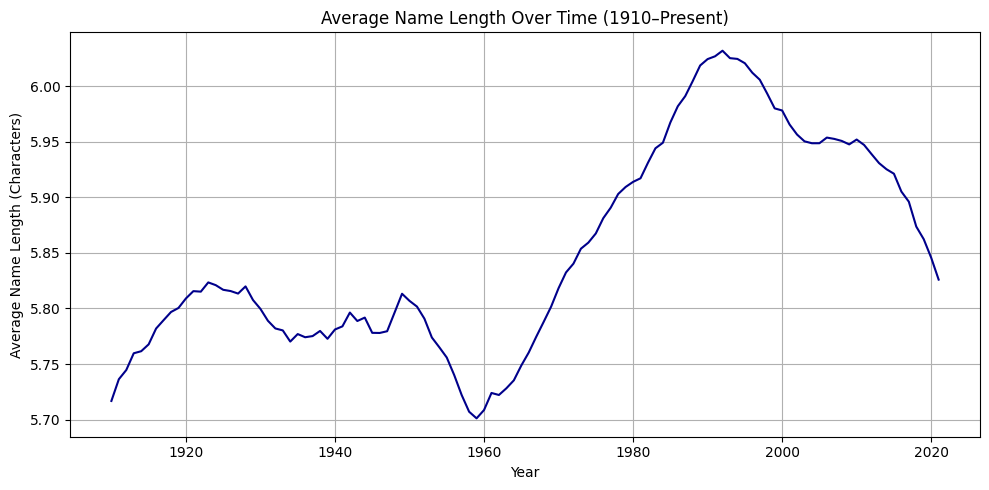

In [10]:
# Query average name length per year
query = """
SELECT
  year,
  AVG(LENGTH(name)) AS avg_name_length
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY year
ORDER BY year
"""
df = client.query(query).to_dataframe()

# Plot the trend over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df["year"], df["avg_name_length"], color='darkblue')
plt.title("Average Name Length Over Time (1910–Present)")
plt.xlabel("Year")
plt.ylabel("Average Name Length (Characters)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight: Average Name Length Over Time

The graph shows that name lengths declined around 1960, peaked near 1990, and have slightly decreased since. This suggests shifting cultural preferences toward shorter or longer names over time. <br><br><br><br>


### Analysis: Gender Ratio Over Time

This analysis calculates the proportion of female births out of the total births for each year. It helps identify demographic shifts and potential cultural changes in name assignments over time.

The query uses simple conditional aggregation and does not scan a large volume of data.


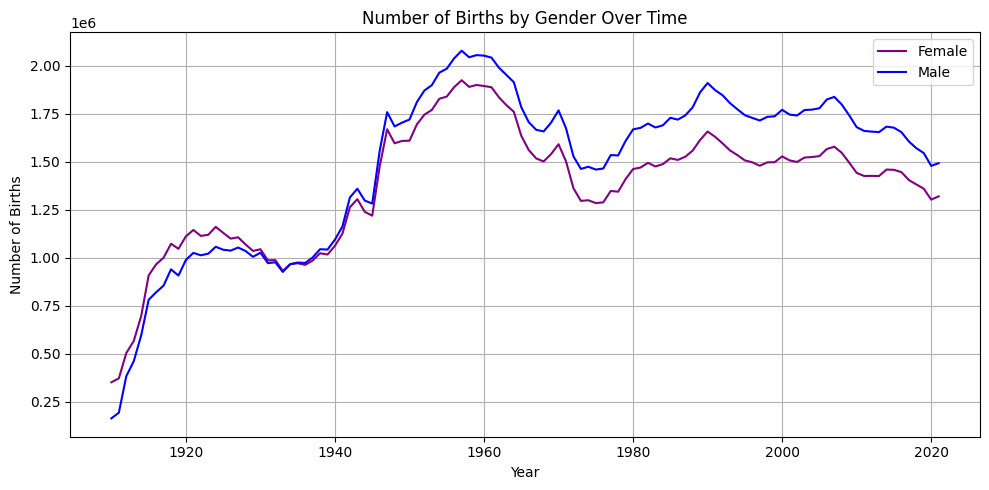

In [16]:
query = """
SELECT
  year,
  SUM(CASE WHEN gender = 'F' THEN number ELSE 0 END) AS female,
  SUM(CASE WHEN gender = 'M' THEN number ELSE 0 END) AS male
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY year
ORDER BY year
"""
df = client.query(query).to_dataframe()

# Plot both series
plt.figure(figsize=(10, 5))
plt.plot(df["year"], df["female"], label="Female", color="purple")
plt.plot(df["year"], df["male"], label="Male", color="blue")

plt.title("Number of Births by Gender Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Births")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight: Number of Births by Gender Over Time

The chart shows the yearly number of male and female births in the United States from 1910 to the present. Male births have consistently outnumbered female births, with both trends generally following similar historical patterns. Notable dips and rises may reflect demographic or historical events such as wars or baby booms.<br><br><br><br>


### Analysis: Most Popular Name per Decade

This analysis identifies the single most popular baby name in each decade from 1910 onward. It highlights long-term naming trends and dominant names by aggregating name counts per decade and selecting the top name per group.


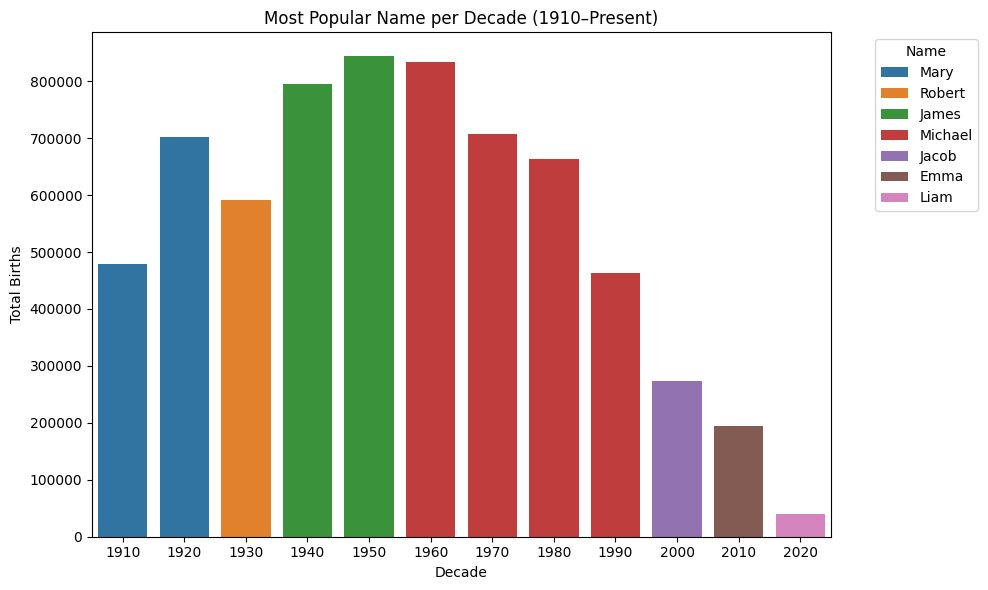

In [17]:
# Step 1: Query to get the most popular name per decade using BigQuery
query = """
WITH name_totals AS (
  -- Aggregate total births by name, gender, and decade
  SELECT
    name,
    gender,
    CAST(FLOOR(year / 10) * 10 AS INT64) AS decade,
    SUM(number) AS total
  FROM `bigquery-public-data.usa_names.usa_1910_current`
  GROUP BY name, gender, decade
),
ranked AS (
  -- Rank names within each decade based on total births
  SELECT *,
         RANK() OVER (PARTITION BY decade ORDER BY total DESC) AS rnk
  FROM name_totals
)
-- Select only the top-ranked (most popular) name for each decade
SELECT name, gender, decade, total
FROM ranked
WHERE rnk = 1
ORDER BY decade
"""

# Step 2: Execute the query and load results into a DataFrame
df = client.query(query).to_dataframe()

# Step 3: Visualize results using a barplot (1 name per decade)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Bar plot showing the most popular name per decade
sns.barplot(data=df, x="decade", y="total", hue="name", dodge=False)

plt.title("Most Popular Name per Decade (1910–Present)")
plt.xlabel("Decade")
plt.ylabel("Total Births")

# Display legend outside the plot
plt.legend(title="Name", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Insight: Most Popular Name per Decade (1910–Present)

The chart shows the top baby name in the United States for each decade, highlighting dominant names and long-term trends. Names like "James" and "Michael" maintained popularity over multiple decades, while recent decades show more variation and decline in total counts, possibly reflecting greater name diversity. Notably, male names dominate the earlier decades, with female names such as "Emma" and "Mary" appearing in specific peaks. <br><br><br><br>


### Analysis: Gender-Neutral Names

This query identifies names that have been used for both male and female babies, suggesting they are gender-neutral or unisex.

It filters names that appear at least once for each gender.


In [14]:
query = """
SELECT name, COUNT(DISTINCT gender) AS genders, SUM(number) AS total
FROM `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY name
HAVING genders = 2 AND total > 2000
ORDER BY total DESC
LIMIT 15
"""
df = client.query(query).to_dataframe()
df


,name,genders,total
0,James,2,5054074
1,John,2,4910976
2,Robert,2,4763102
3,Michael,2,4396482
4,William,2,3939912
5,Mary,2,3757625
6,David,2,3631489
7,Joseph,2,2554530
8,Richard,2,2550606
9,Charles,2,2299419


### Insight: Most Common Gender-Neutral Names by Total Births

This table lists the most common names that have appeared for **both genders** (`genders = 2`) across U.S. birth records. The names "James", "John", and "Robert" top the list with over 4 million total occurrences each, indicating widespread use and cultural persistence.

Interestingly, most of the top gender-neutral names are traditionally male-associated names that have also been used (to a lesser extent) for females. This suggests that historically masculine names may occasionally cross gender boundaries, while the reverse is less common. The presence of "Mary" and "Patricia" also highlights exceptions, reinforcing that gendered naming norms are not absolute. <br><br><br><br>

### Analysis: Gender Flip – Names That Switched Dominant Gender

This analysis identifies names that were once primarily associated with one gender and later became more common for the opposite gender. It highlights cultural changes in name perception over time.


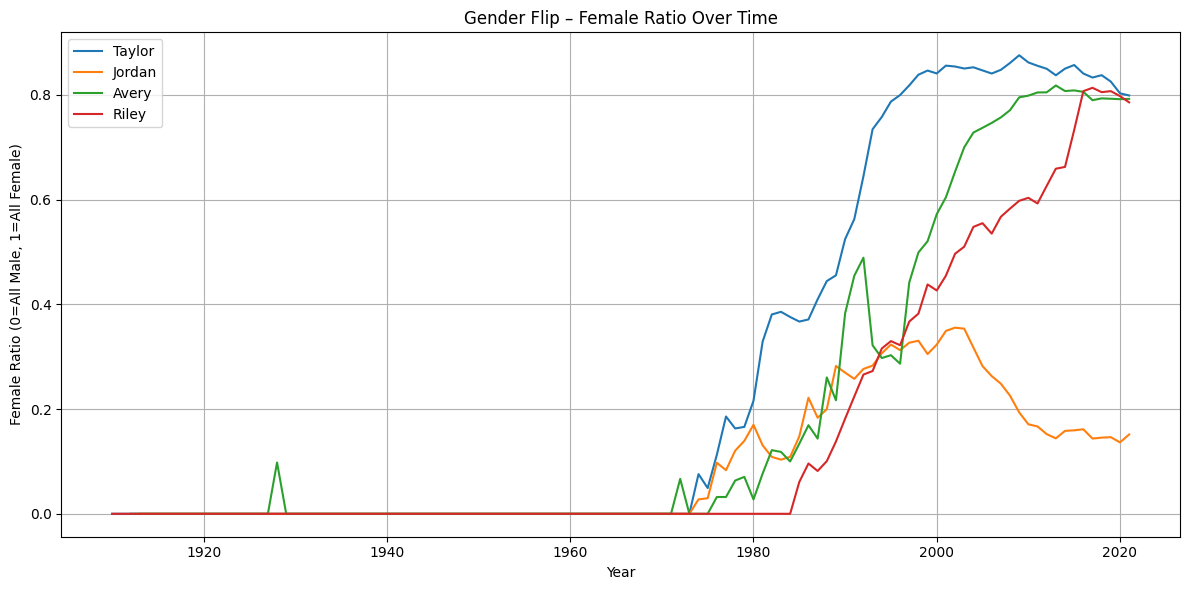

In [22]:
# Get the gender ratio of selected names by year
names_to_check = ["Taylor", "Jordan", "Avery", "Riley"]
name_list = ",".join([f"'{n}'" for n in names_to_check])

query = f"""
SELECT
  name,
  year,
  SUM(CASE WHEN gender = 'F' THEN number ELSE 0 END) AS female,
  SUM(CASE WHEN gender = 'M' THEN number ELSE 0 END) AS male
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name IN ({name_list})
GROUP BY name, year
ORDER BY year
"""
df = client.query(query).to_dataframe()

# Calculate female ratio and plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name in names_to_check:
    df_name = df[df["name"] == name].copy()
    df_name["ratio"] = df_name["female"] / (df_name["female"] + df_name["male"])
    plt.plot(df_name["year"], df_name["ratio"], label=name)

plt.title("Gender Flip – Female Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Female Ratio (0=All Male, 1=All Female)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight: Gender Flip – Female Ratio Over Time

The chart illustrates how certain names, such as Taylor, Avery, and Riley, have shifted over time from being predominantly male to predominantly female. Taylor shows a strong flip in the 1980s, reaching over 85% female usage by the 1990s. Avery and Riley follow a similar pattern with later shifts. Jordan is more balanced but demonstrates a temporary rise in female usage before declining again. This trend reflects evolving gender associations and cultural perceptions of names.<br><br><br><br>


### Analysis: Name Lifecycle – Growth, Peak, and Decline

This visualization tracks the full lifecycle of a single name over time, highlighting its rise, peak popularity, and decline. It is useful to understand temporal name trends and generational cycles.


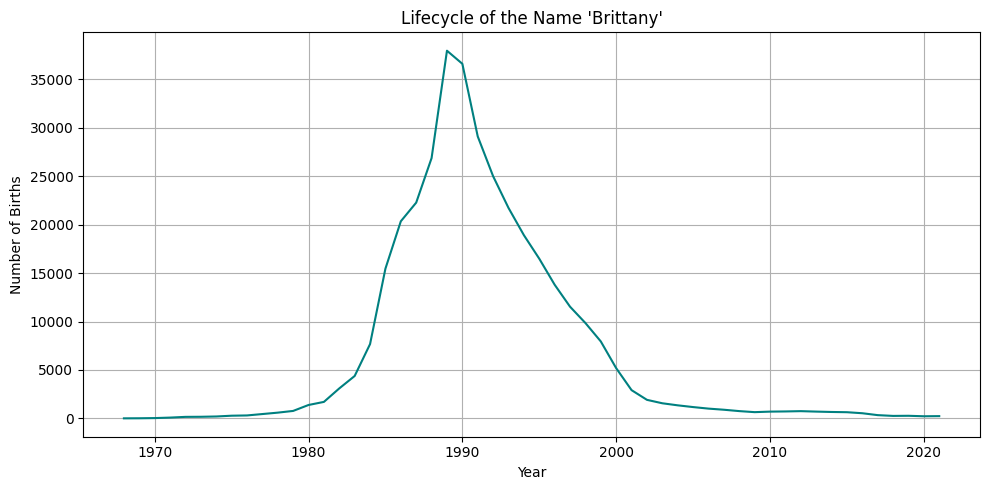

In [19]:
# Query yearly total for a selected name
selected_name = "Brittany"

query = f"""
SELECT year, SUM(number) AS total
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE name = '{selected_name}'
GROUP BY year
ORDER BY year
"""
df = client.query(query).to_dataframe()

# Plot lifecycle curve
plt.figure(figsize=(10, 5))
plt.plot(df["year"], df["total"], color="teal")
plt.title(f"Lifecycle of the Name '{selected_name}'")
plt.xlabel("Year")
plt.ylabel("Number of Births")
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight: Lifecycle of the Name 'Brittany'

The graph shows the rise and fall of the name "Brittany" over time. It gained rapid popularity in the 1980s, peaking sharply around 1989 with over 37,000 births. Following that, it declined just as quickly, nearly disappearing by the 2000s. This pattern reflects a classic short-lived naming trend, likely driven by pop culture or media influences during that period.
